# WiDS Kaggle Competition

Work in progress...

### Ideas
- data augmentation
- train to score directly instead of binary?
- use scores as weights
- normalize intensity of images

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import glob
from sklearn.metrics import roc_auc_score

from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD

In [2]:
sns.set(font_scale=1.5, style='white')

## Data Exploration

In [3]:
train_files = glob.glob('train_images/*')
len(train_files)

15244

In [4]:
train_files[0]

'train_images/img_068062017.jpg'

In [5]:
img = mpimg.imread(train_files[0])
img.shape  # 256 by 256 pixels, 3 channels

(256, 256, 3)

In [6]:
df_labels = pd.read_csv('traininglabels.csv')
df_labels.sample(10)

,image_id,has_oilpalm,score
10233,img_039772018.jpg,1,1.0000
5625,img_082232017.jpg,0,1.0000
9733,img_032612018.jpg,0,1.0000
13937,img_094022018.jpg,0,1.0000
12076,img_066272018.jpg,0,1.0000
1403,img_020332017.jpg,0,1.0000
13309,img_084972018.jpg,0,0.8047
14963,img_108562018.jpg,0,1.0000
14163,img_097232018.jpg,0,1.0000
12667,img_075212018.jpg,0,1.0000


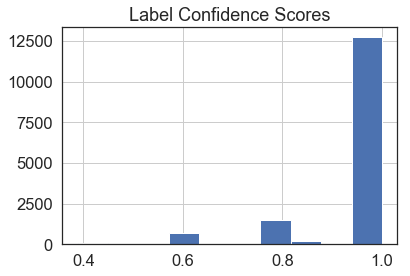

In [7]:
df_labels.score.hist()
plt.title('Label Confidence Scores');

### Classes are very imbalanced

In [8]:
df_labels.has_oilpalm.value_counts()

0    14302
1      942
Name: has_oilpalm, dtype: int64

In [9]:
df_labels.has_oilpalm.value_counts() / df_labels.shape[0]

0    0.938205
1    0.061795
Name: has_oilpalm, dtype: float64

### Visualize each separate channel of an image

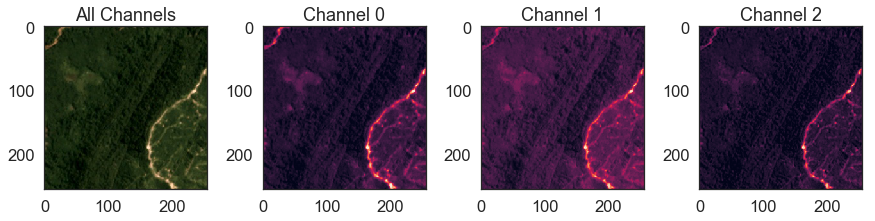

In [10]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
axes[0].imshow(img)
axes[0].set_title('All Channels')
for chan in range(3):
    axes[chan + 1].imshow(img[:, :, chan])
    axes[chan + 1].set_title(f'Channel {chan}');

### Grab a random sample of positive and negative classes for visual inspection

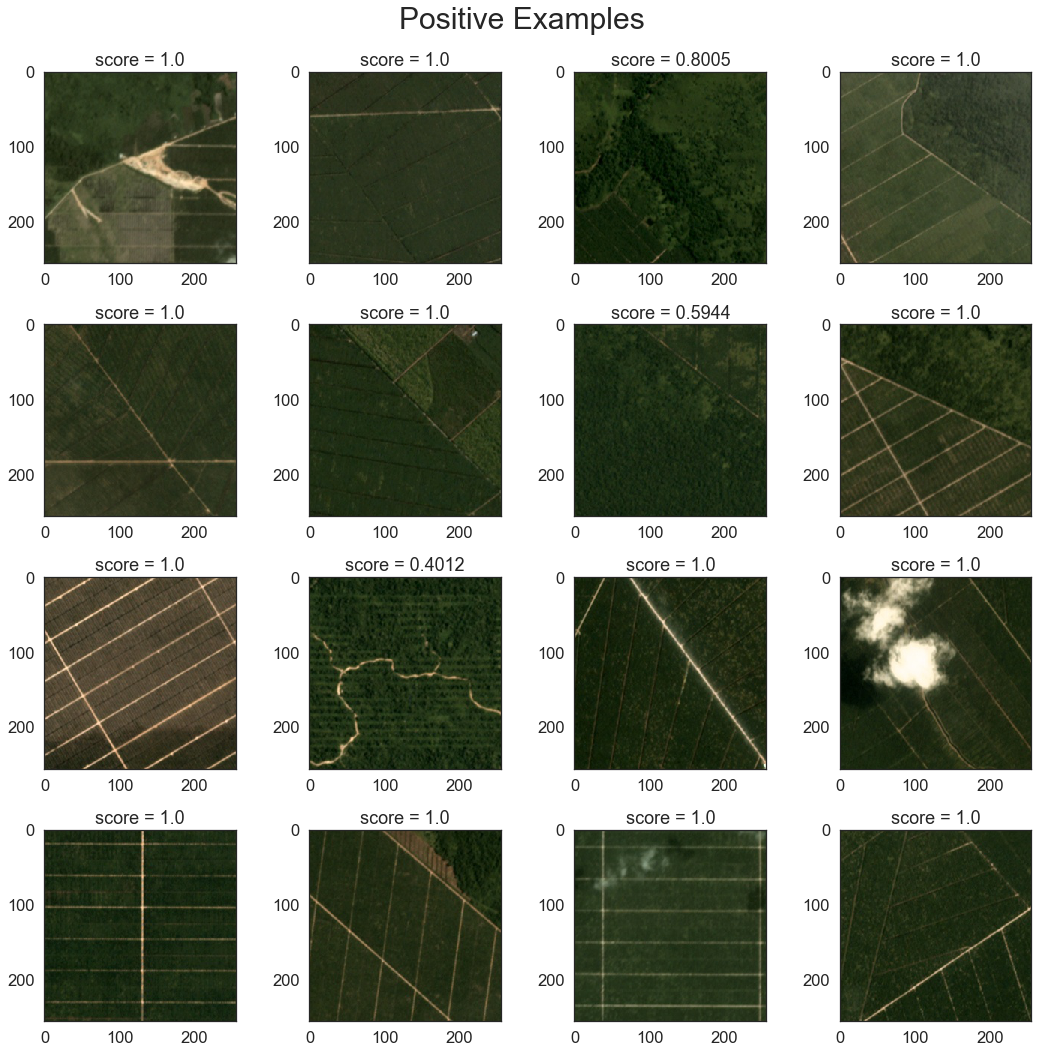

In [11]:
df_pos_examples = df_labels.loc[df_labels.has_oilpalm == 1].sample(16)
pos_examples = df_pos_examples.image_id.values
scores = df_pos_examples.score.values

fig, axes = plt.subplots(4, 4, figsize=(15, 15))
for f, s, ax in zip(pos_examples, scores, np.ravel(axes)):
    ax.imshow(mpimg.imread(f'train_images/{f}'))
    ax.set_title(f'score = {s}')
fig.tight_layout()
fig.suptitle('Positive Examples', size=30)
fig.subplots_adjust(top=0.92)

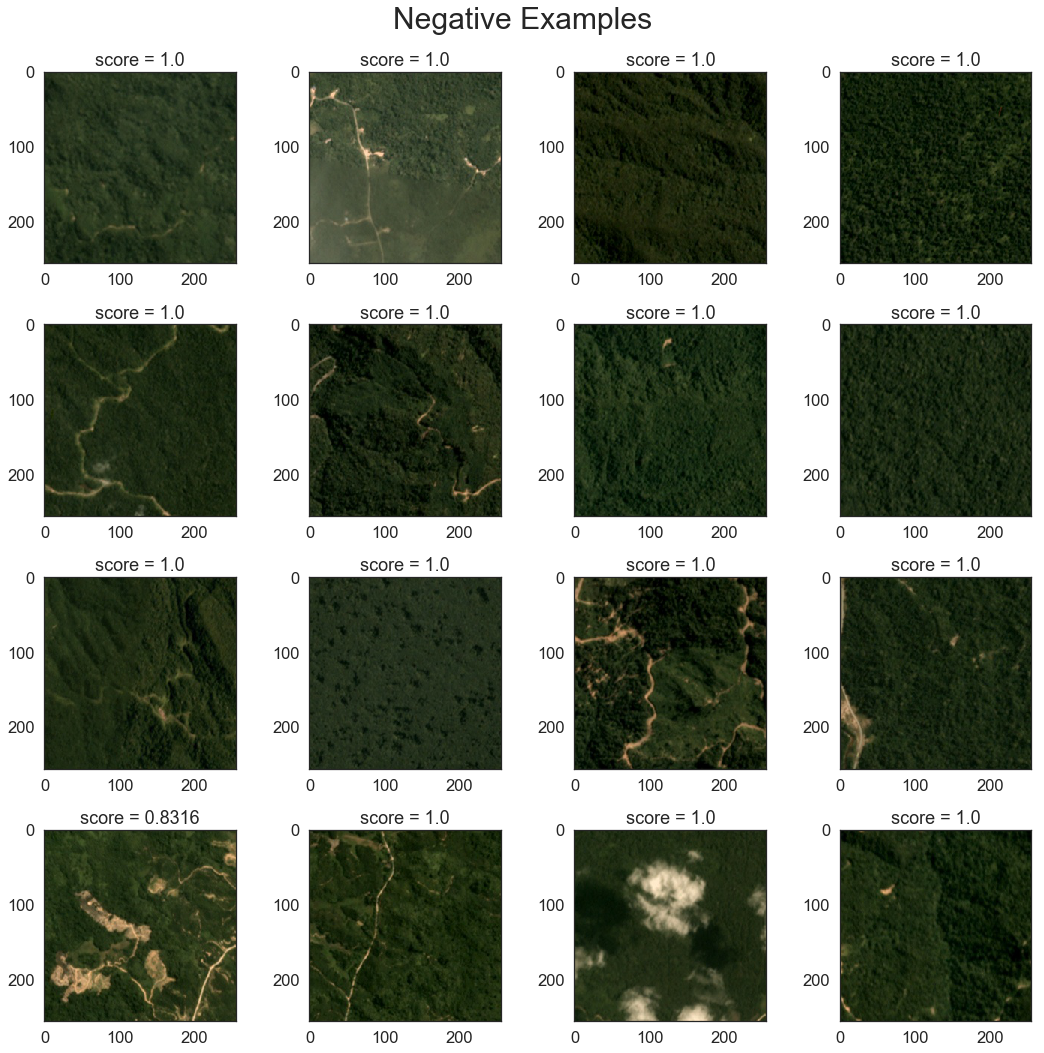

In [12]:
df_neg_examples = df_labels.loc[df_labels.has_oilpalm == 0].sample(16)
neg_examples = df_neg_examples.image_id.values
scores = df_neg_examples.score.values

fig, axes = plt.subplots(4, 4, figsize=(15, 15))
for f, s, ax in zip(neg_examples, scores, np.ravel(axes)):
    ax.imshow(mpimg.imread(f'train_images/{f}'))
    ax.set_title(f'score = {s}')
fig.tight_layout()
fig.suptitle('Negative Examples', size=30)
fig.subplots_adjust(top=0.92)

### What do the distributions of pixel intensities look like?

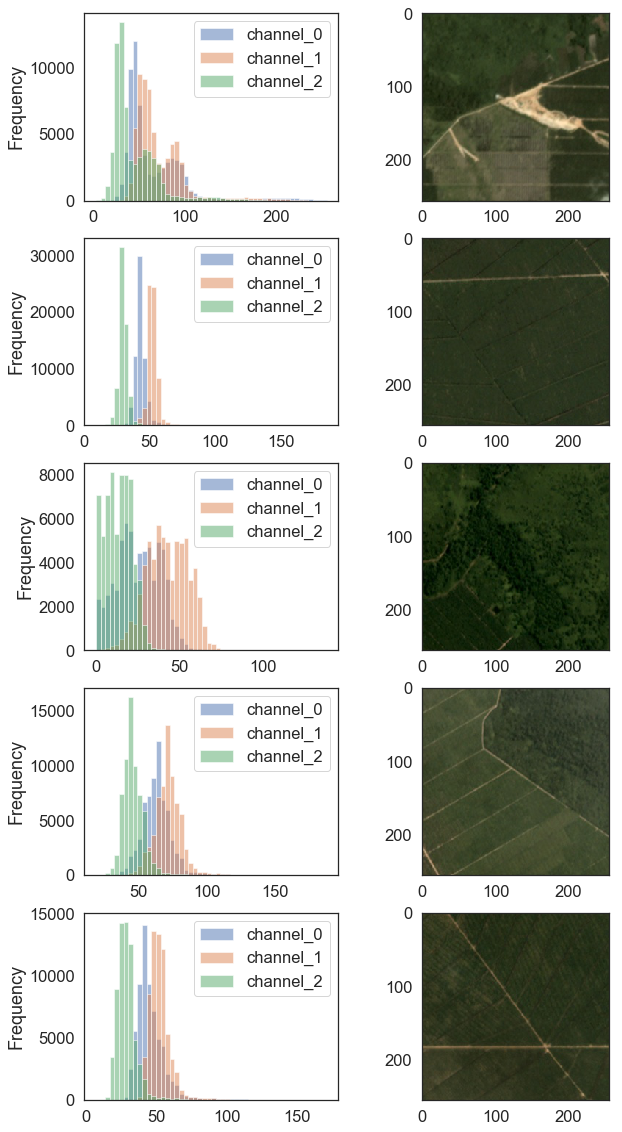

In [13]:
fig, axes = plt.subplots(5, 2, figsize=(10, 20))
for i, f in enumerate(pos_examples[:5]):
    img = mpimg.imread(f'train_images/{f}')
    df_pix_values = pd.DataFrame({f'channel_{j}': img[:, :, j].flatten()
                                  for j in range(3)})
    ax = df_pix_values.plot.hist(alpha=0.5, bins=50, ax=axes[i, 0])
    # ax.set_xlim([0, 250])
    axes[i, 1].imshow(img)

## Model

Before we train on all the data, let's start with a small sample to make sure everything is working...

In [14]:
# random train/val split
df_train = df_labels.sample(frac=0.8, replace=False)
df_val = df_labels.loc[~df_labels.image_id.isin(df_train.image_id.values)]
df_train.shape, df_val.shape

((12195, 3), (3049, 3))

In [15]:
# load image data for just the first 100 images in each train/val dataset

train_images, train_labels = [], []
val_images, val_labels = [], []

balanced_train = pd.concat([
    df_train.loc[df_train.has_oilpalm == 0].sample(100),
    df_train.loc[df_train.has_oilpalm == 1].sample(100)])
balanced_train = balanced_train.sample(frac=1, replace=False)  # shuffle

for f in balanced_train.image_id.values:
    train_images.append(mpimg.imread(f'train_images/{f}'))
    train_labels.append(df_train.loc[df_train.image_id == f].has_oilpalm.values[0])
    
balanced_val = pd.concat([
    df_val.loc[df_val.has_oilpalm == 0].sample(100),
    df_val.loc[df_val.has_oilpalm == 1].sample(100)])
balanced_val = balanced_val.sample(frac=1, replace=False)  # shuffle

for f in balanced_val.image_id.values:
    val_images.append(mpimg.imread(f'train_images/{f}'))
    val_labels.append(df_val.loc[df_val.image_id == f].has_oilpalm.values[0])
    
# cast lists to arrays and normalize to max 1
train_images = np.array(train_images) / 255
train_labels = np.array(train_labels)
val_images = np.array(val_images) / 255
val_labels = np.array(val_labels)

train_images.shape, train_labels.shape, val_images.shape, val_labels.shape

((200, 256, 256, 3), (200,), (200, 256, 256, 3), (200,))

### Build a simple starting model

In [16]:
model = models.Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 252, 252, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 64)        102464    
_________________________________________________________________
flatten (Flatten)            (None, 207936)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                13307968  
__________

In [18]:
learning_rate = 0.01
model.compile(optimizer=SGD(lr=learning_rate),
              loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
history = model.fit(train_images, train_labels, epochs=15, batch_size=16,
                    validation_data=(val_images, val_labels))

Train on 200 samples, validate on 200 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/15
200/200 [==============================] - 54s 272ms/sample - loss: 0.6996 - acc: 0.4300 - val_loss: 0.6851 - val_acc: 0.5000
Epoch 2/15
200/200 [==============================] - 47s 236ms/sample - loss: 0.6863 - acc: 0.5000 - val_loss: 0.6818 - val_acc: 0.5100
Epoch 3/15
200/200 [==============================] - 44s 222ms/sample - loss: 0.6797 - acc: 0.5600 - val_loss: 0.6706 - val_acc: 0.5150
Epoch 4/15
200/200 [==============================] - 44s 220ms/sample - loss: 0.6656 - acc: 0.6250 - val_loss: 0.6516 - val_acc: 0.6000
Epoch 5/15
200/200 [==============================] - 44s 218ms/sample - loss: 0.6501 - acc: 0.6350 - val_loss: 0.6848 - val_acc: 0.5300
Epoch 6/15
200/200 [==============================] - 44s 218ms/sample - loss: 0.6444 - acc: 0.6350 - val_loss: 0.6255 - val_acc: 0.7050
Epoch 7/15
200/200 [==============================] - 44s 220ms/sample - loss: 0.624

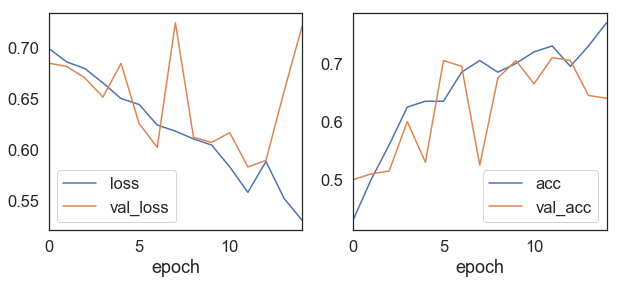

In [22]:
df_history = pd.DataFrame(history.history)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

df_history[['loss', 'val_loss']].plot(ax=axes[0])
axes[0].set_xlabel('epoch')

df_history[['acc', 'val_acc']].plot(ax=axes[1])
axes[1].set_xlabel('epoch');

In [23]:
val_pred = model.predict(val_images)
auc = roc_auc_score(val_labels, val_pred)
print(f'Validation AUC: {auc:.3f}')

Validation AUC: 0.766


### Next up

Figure out how to train on full dataset.